# set up


In [ ]:
#connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive
#%cd ../..
!pwd



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive
/content/gdrive/MyDrive


In [ ]:
%cd competitions/hw5

/content/gdrive/MyDrive/competitions/hw5


# preprocessing

In [ ]:
from torch.autograd import Variable
import torch.optim as optim
from PIL import Image
import PIL.ImageOps  
from torchvision import transforms
import numpy as np
from os import listdir
import torchvision
import torch
from torchvision.utils import save_image
from torch import nn

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:

def is_image(filename):
  return any(filename.endswith(extension) for extension in ['png'])


class TrainDataset(object):
    def __init__(self,lrimagefolder,hrimagefolder,transform=None,should_invert=False, test = False):
        super(TrainDataset,self).__init__()
        
        self.hrimagefolder = hrimagefolder
        self.lrimagefolder = lrimagefolder  
        if transform:
          self.transformhr = transform[0]
          self.transformlr = transform[1]
        else:
          self.transformhr = None
          self.transformlr = None
        self.should_invert = should_invert
        self.hrdir = sorted(listdir(hrimagefolder))
        self.lrdir = sorted(listdir(lrimagefolder))
        self.test = test


    def __getitem__(self,index):

        dirnamehr =  self.hrimagefolder + '/' + self.hrdir[index]
        dirnamelr =  self.lrimagefolder + '/' + self.lrdir[index]


        imghr = Image.open(dirnamehr)
        imglr = Image.open(dirnamelr)
        

        if self.transformlr is not None:

          imghr = self.transformhr(imghr)
          imglr = self.transformlr(imglr)
        
        p = np.random.random()
        if p > 0.5:
            imglr = torchvision.transforms.functional.hflip(imglr)
            imghr = torchvision.transforms.functional.hflip(imghr)

        imghr = transforms.ToTensor()(imghr)
        imglr = transforms.ToTensor()(imglr)

      
        if self.test == False:
          return imghr, imglr
        """
        else:
          return img0, img1 ,0
        """
    
    def __len__(self):
        return len(self.hrdir)

In [ ]:
import torchvision
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
crop_size = 400
upscale_factor = 4
t = [torchvision.transforms.Compose([Resize((crop_size, crop_size))]),
     torchvision.transforms.Compose([Resize((crop_size // upscale_factor, crop_size//upscale_factor)),])]
t = [torchvision.transforms.Compose([transforms.CenterCrop(400),]),torchvision.transforms.Compose([transforms.CenterCrop(100),])]
lrimagefolder = 'DIV2K_train_LR_bicubic/X4'
hrimagefolder = 'DIV2K_train_HR'
train_dataset = TrainDataset(lrimagefolder, hrimagefolder, transform=t)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, num_workers = 0, batch_size = 4)


In [ ]:

t = [torchvision.transforms.Compose([transforms.CenterCrop(600),]),torchvision.transforms.Compose([transforms.CenterCrop(150),])]
lrimagefolder = 'DIV2K_valid_LR_bicubic/X4'
hrimagefolder = 'DIV2K_valid_HR'

valid_dataset = TrainDataset(lrimagefolder, hrimagefolder, transform=None)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle = False, num_workers = 0, batch_size = 1)


torch.Size([1, 3, 1356, 2040]) torch.Size([1, 3, 339, 510])


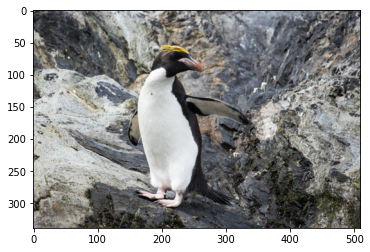

In [ ]:
import matplotlib.pyplot as plt

for a, b in valid_dataloader:
  print(a.shape, b.shape)

  plt.imshow( b[0].permute(1, 2, 0)  )
  del a
  del b
  break


# model

In [ ]:


class ResidualDenseBlock(nn.Module):
    def __init__(self, channels = 64, growth_channels = 32, scale_ratio = 0.2):

        super(ResidualDenseBlock, self).__init__()
        convlayer = []
        for i in range(5):
          if i != 4:
            
            convlayer.append(nn.Conv2d(channels + i* growth_channels, growth_channels, kernel_size=3, stride=1, padding=1))
          else:
            convlayer.append(nn.Conv2d(channels + i* growth_channels, channels, kernel_size=3, stride=1, padding=1))
        self.convlayer = nn.Sequential(*convlayer)
        self.scale_ratio = scale_ratio
        self.relu = nn.LeakyReLU(negative_slope = 0.2, inplace = True)


    def forward(self, x) :

        origin_x = x
        catlayer = []
        for num,l in enumerate(self.convlayer):
          
          if num == 0:
            catlayer.append(x)
            x = self.relu(l(x))
          elif num> 0 and num< 4 :
            
            catlayer.append(x)
            
            input = torch.cat(catlayer,1)
            x = self.relu(l(input))
          else:
            catlayer.append(x)
            input = torch.cat(catlayer,1)
            x = l(input)

        return x * self.scale_ratio + origin_x

In [ ]:
class RRDB(nn.Module):

    def __init__(self, channels = 64, growth_channels=32,scale_ratio = 0.2):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock(channels, growth_channels,scale_ratio )
        self.RDB2 = ResidualDenseBlock(channels, growth_channels,scale_ratio)
        self.RDB3 = ResidualDenseBlock(channels, growth_channels,scale_ratio)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

In [ ]:
class upsampleblock(torch.nn.Module):
  def __init__(self, in_channel, scale = 2):
    super(upsampleblock, self).__init__()
    self.conv = nn.Conv2d(in_channel, in_channel *scale * 2, kernel_size = 3, stride = 1, padding = 1)
    self.pixel_shuffle = nn.PixelShuffle(upscale_factor = scale)
    self.prelu = nn.PReLU()
  
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [ ]:

class Generator(nn.Module):
    def __init__(self, num_rrdb= 12):
        super(Generator, self).__init__()
        #p1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        rrdblayers = []
        for _ in range(num_rrdb):
            rrdblayers.append(RRDB(channels=64, growth_channels=32, scale_ratio=0.2))

        self.rrdb= nn.Sequential(*rrdblayers)

        # p2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # p3 with upsample
        upsample_num = 2
        upblock = []
        for i in range(upsample_num):
          upblock.append(upsampleblock(64))
          
        self.upblock = nn.Sequential(*upblock)

        # p3 conv
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Final output layer
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        rrdblyr = self.rrdb(out)
        out2 = self.conv2(rrdblyr)
        out = torch.add(out, out2)
        out = self.upblock(out)
        out = self.conv3(out)
        out = self.conv4(out)

        return out

In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    block_channel = [64, 128, 256, 512]#original: 64, 128, 256, 512

    longblock = []
    inchannel = 3
    out = 64
    for b in range(len(block_channel)):
      out = block_channel[b]
      if b == 0:
        longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 1, padding = 1))
        longblock.append(nn.LeakyReLU(0.2))
      else:
        longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 1, padding = 1))
        longblock.append(nn.BatchNorm2d(out))
        longblock.append(nn.LeakyReLU(0.2))
      inchannel = out
      longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 2, padding = 1))
      longblock.append(nn.BatchNorm2d(out))
      longblock.append(nn.LeakyReLU(0.2))
    
    self.longblock = nn.Sequential(*longblock)
    
    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 100, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(100,1, kernel_size = 1) 
    )

  def forward(self,x):

    x = self.longblock(x)
    x = self.classifier(x)
    x = x.flatten(start_dim = 1)
    
    return x


#training

In [ ]:
from torch import nn
from torchvision.models.vgg import vgg19


class GeneratorLoss(nn.Module):
    def __init__(self, before_act = True):
        super(GeneratorLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        vggloss= nn.Sequential(*list(vgg.features)[:6]).eval()  #6, 

        for param in vggloss.parameters():
            param.requires_grad = False
        self.vggloss = vggloss.to(device)

        self.l1_loss = nn.L1Loss().to(device)
        self.gen_loss = nn.BCEWithLogitsLoss()

    def forward(self, out_labels,out_target_labels, out_images, target_images, warmup = False):
 
        out_labels = out_labels.squeeze(1)
        
        g_real = self.gen_loss((out_labels - torch.mean(out_target_labels)), 
                               torch.ones_like(out_labels, dtype = torch.float))
        g_fake = self.gen_loss((out_target_labels - torch.mean(out_labels)), 
                               torch.zeros_like(out_labels, dtype = torch.float))
        gloss = (g_real + g_fake) /2

        vgg_loss = self.l1_loss(self.vggloss(out_images), self.vggloss(target_images))

        self.image_loss = self.l1_loss(out_images, target_images)
        
    
        return 0.01 * self.image_loss + 1* vgg_loss + 0.006*gloss




In [ ]:

def training(epoch, G_optimizer, D_optimizer, lr,netG, netD, train_dataloader = None):
  gloss = 0
  dloss = 0
  dscore = 0
  gscore = 0

  netG.train()
  netD.train()
  criterion_pixel = torch.nn.L1Loss().to(device)

  
  for i,(imagehr, imagelr) in enumerate(train_dataloader):
    batches = (epoch+1) * 200 + i   
    G_optimizer.zero_grad()
    imagelr = Variable(imagelr).to(device) 
    imagehr = Variable(imagehr).to(device)
    if batches < 400:
      print(batches_done)
      fakeimg = netG(imagelr)
      warmuploss = criterion_pixel(fakeimg, imagehr)
      warmuploss.backward()
      G_optimizer.step()
      print('warmup')
      del fakeimg
      del warmuploss
      del imagelr
      del imagehr
      continue
    ##########################################discriminator##############################################
    imagehr = Variable(imagehr).to(device)
    imagelr = Variable(imagelr).to(device)   
   
    torch.cuda.empty_cache()

    D_optimizer.zero_grad()

    real_label = torch.full(size=(len(imagehr),), fill_value=0.99, dtype=torch.float, device=device)
    realout = netD(imagehr).view(-1)

    err_D_real = dcriterion(realout, real_label)
    err_D_real.backward(retain_graph=True)

    fake_label = torch.full(size=(len(imagehr),), fill_value=0, dtype=torch.float, device=device)
    fakeimg = netG(imagelr)
    
    fakeout = netD(fakeimg.detach()).view(-1)
    err_D_fake = dcriterion(fakeout, fake_label)
    err_D_fake.backward(retain_graph=True)

    D_optimizer.step()
    
    dloss += err_D_fake.item() + err_D_real.item()
    
    
    del realout
    del real_label
    del err_D_real
    del fakeout
    
    #############################################generator#####################################################
  
    torch.cuda.empty_cache()
    #G_optimizer.zero_grad()
    # criterion
    fakeout = netD(fakeimg)
    realout = netD(imagehr).view(-1)
    g_loss = gcriterion(fakeout, realout,fakeimg, imagehr)

    gloss += g_loss.item()

    g_loss.backward(retain_graph=True)
    G_optimizer.step()

    del realout
    del imagehr
    del imagelr
    del fakeout
    del fakeimg
    del g_loss
    
  
  print('epoch',epoch,'gloss: ', gloss, ' dloss:', dloss)

  torch.cuda.empty_cache()

from math import log10
def val(netG, netD, valid_dataloader=None):
  netG.eval()
  netD.eval()

  psnr_total = []
  ssim_total = []

  with torch.no_grad():
    for imagehr, imagelr in valid_dataloader:

      imagehr = Variable(imagehr).to(device)
      imagelr = Variable(imagelr).to(device)   
      fakeimg = netG(imagelr)

      s = ssim(imagehr, fakeimg)
      ssim_total.append(s.item())

      p =  ((imagehr - fakeimg) ** 2).data.mean()
      psnr = 10 * log10(1 / p)
      psnr_total.append(psnr)

      del imagehr
      del imagelr
      del fakeimg
      torch.cuda.empty_cache()
    scheduler.step()
    print('psnr: ',np.mean(psnr_total), 'ssim: ',np.mean(ssim_total))
    return np.mean(psnr_total)
    



# Tuning

In [ ]:
from math import exp

import torch
import torch.nn.functional 
from torch.autograd import Variable



def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = torch.nn.functional.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = torch.nn.functional.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = torch.nn.functional.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = torch.nn.functional.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = torch.nn.functional.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
netG = Generator()
netD = Discriminator()
netG.to(device)
netD.to(device)

lr = 0.0003
epochs = 30
bestval = 21
gcriterion = GeneratorLoss()
dcriterion = nn.BCEWithLogitsLoss()

G_optimizer = optim.Adam(netG.parameters(), lr = lr, betas = (0.9, 0.999))
D_optimizer = optim.Adam(netD.parameters(), lr = lr, betas = (0.9, 0.999))
#scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, 'min', 0.75,2)
scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, step_size=5, gamma=0.5)

for epoch in range(1,epochs):
  training(epoch, G_optimizer, D_optimizer, lr,netG, netD, train_dataloader=train_dataloader)
  curval = val(netG, netD, valid_dataloader=valid_dataloader)
  if curval > bestval:
    torch.save(netG,'netgers_report9')
    torch.save(netD,'netders_report9')
    print('saving model...')
    bestval = curval


saving...
saving...
epoch 1 gloss:  137.27107790112495  dloss: 249.72941707074642
psnr:  20.931551024388487 ssim:  0.6200520873069764
saving...
saving...
epoch 2 gloss:  127.7770619392395  dloss: 270.78966706991196
psnr:  22.348367358146724 ssim:  0.6468349325656891
saving model...
saving...
saving...
epoch 3 gloss:  125.8286695331335  dloss: 271.97641214728355
psnr:  23.132520131329485 ssim:  0.6603327322006226
saving model...
saving...
saving...
epoch 4 gloss:  124.45104077458382  dloss: 275.1051904261112
psnr:  21.60286995558334 ssim:  0.652691875398159
saving...
saving...
epoch 5 gloss:  124.09386190772057  dloss: 272.3828456401825
psnr:  24.255725929430376 ssim:  0.6578166019916535
saving model...
saving...
saving...
epoch 6 gloss:  123.18069502711296  dloss: 236.77124126255512
psnr:  24.03315937021848 ssim:  0.6643211409449578
saving...
saving...
epoch 7 gloss:  124.54489970207214  dloss: 176.69090063497424
psnr:  15.971181477689727 ssim:  0.4912819290161133
saving...
saving...
e